In [19]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import numpy as np 
import pandas as pd

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score

!pip install xgbfir
import xgbfir
!pip install lofo-importance
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

In [20]:
train = pd.read_csv("kaggle/wids-training.csv")
test =  pd.read_csv("kaggle/wids-test.csv")

In [21]:
print(f"The data consists of {train.shape[0]} rows, and {train.shape[1]} columns")

The data consists of 12906 rows, and 83 columns


In [22]:
#This code calculate the percentage of missing data per every row.
for column in train.columns:
    null_count = train[column].isnull().sum()
    if null_count > 0:
        percent_nulls = (null_count / train.shape[0]) * 100
        print(f'{column} : {percent_nulls:.2f}% nulls')

patient_race : 49.47% nulls
payer_type : 13.97% nulls
patient_state : 0.40% nulls
bmi : 69.46% nulls
metastatic_first_novel_treatment : 99.81% nulls
metastatic_first_novel_treatment_type : 99.81% nulls
Region : 0.40% nulls
Division : 0.40% nulls
population : 0.01% nulls
density : 0.01% nulls
age_median : 0.01% nulls
age_under_10 : 0.01% nulls
age_10_to_19 : 0.01% nulls
age_20s : 0.01% nulls
age_30s : 0.01% nulls
age_40s : 0.01% nulls
age_50s : 0.01% nulls
age_60s : 0.01% nulls
age_70s : 0.01% nulls
age_over_80 : 0.01% nulls
male : 0.01% nulls
female : 0.01% nulls
married : 0.01% nulls
divorced : 0.01% nulls
never_married : 0.01% nulls
widowed : 0.01% nulls
family_size : 0.03% nulls
family_dual_income : 0.03% nulls
income_household_median : 0.03% nulls
income_household_under_5 : 0.03% nulls
income_household_5_to_10 : 0.03% nulls
income_household_10_to_15 : 0.03% nulls
income_household_15_to_20 : 0.03% nulls
income_household_20_to_25 : 0.03% nulls
income_household_25_to_35 : 0.03% nulls


In [23]:
#Dropping high nulls columns 
for column in train.columns:
    null_count = train[column].isnull().sum()
    percent_nulls = (null_count / train.shape[0]) * 100
    if percent_nulls > 1:
        train.drop(columns = column,axis = 1,inplace=True)
        test.drop(columns = column,axis = 1,inplace=True)

In [24]:
#checking if test and train has the same shape
print(f"Train data: {train.shape} \nTest data: {test.shape}")

Train data: (12906, 78) 
Test data: (5792, 77)


In [25]:
#Let's create a panel so that if we want to add features and make changes, we can do that at once in train and test data(create simplicity :-)

train['is_train'] = 1

In [26]:
test['is_train'] = 0

In [27]:
panel = pd.concat([train, test], axis=0)

In [28]:
#here we are dealing with missing values at once(train and test data) by using panel.

categorical_cols = panel.select_dtypes(include=['object', 'category']).columns
numerical_cols = panel.select_dtypes(include=['float64', 'int64']).columns

# Impute categorical columns using mode
for col in categorical_cols:
    mode = panel[col].mode()[0]
    panel[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    mean = panel[col].mean()
    panel[col].fillna(mean, inplace=True)

In [29]:
#creating panel df was most important for doing label encoding because you want to deal with test and train df at once and not separately.

categorical_cols = panel.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    panel[col] = le.fit_transform(panel[col])

In [30]:
#assigning dfs back to their respective datasets
train = panel.loc[(panel['is_train'] == 1)]
test = panel.loc[(panel['is_train'] == 0)]

In [31]:
#checking if the train and test have same number of columns
test.shape, train.shape

((5792, 79), (12906, 79))

In [32]:
feature_col = np.setdiff1d(train.columns,['DiagPeriodL90D', 'patient_id']) #removing patient-id because it doesnt have to do anything with the data
target = 'DiagPeriodL90D'

train_X = train[feature_col]
train_y = train[target]

test_X = test[feature_col]

# split train into tr and val

tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.20, random_state=1)

In [33]:
%%time

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
auc_score_list = []
model_predsLGBM = []

print(skf)
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={val_index}")
    tr_X = train_X.loc[train_index] # 7/8th of training set is here
    val_X = train_X.loc[val_index] # 1/8th of training set is here
    
    tr_y = train_y.loc[train_index] # 7/8th of training set classes are here
    val_y = train_y.loc[val_index] # 1/8th of training set classes are here
    
    #building the model 
    
    clf = LGBMClassifier(#objective='binary',
    #boosting_type='gbdt',
    colsample_bytree=0.60,
    reg_lambda=1.00,
    reg_alpha=1.00,
    learning_rate=0.01,
    max_depth=6,
    min_child_samples=3,
    min_child_weight=8.00162004247609,
    #min_gain_to_split=0.05772859122473113,
    n_estimators=1500,
    num_leaves=63,
    subsample=0.90,
    #device='gpu',
    verbosity=-1,
    random_state=42) # model initializing
    
    ## training
    clf.fit(tr_X, tr_y) # building model on 7/8th of training set features and labels
    val_fold_preds = clf.predict_proba(val_X)[:,1] # validating model (get predictions) on 1/8th of training set features and labels on val set
    
    ## local validation
 
    #calculating auc for each fold
    auc_score = roc_auc_score(val_y,val_fold_preds)
    auc_score_list.append(auc_score)
    print("fold: ", i, ". auc_score: ", auc_score)
    
    ## predictions for lb
    #Oof model prediction
    test_fold_preds = clf.predict_proba(test_X)[:,1] # get predictions on entire test set
    model_predsLGBM.append(test_fold_preds) # saving these test predictions into a list

StratifiedKFold(n_splits=8, random_state=42, shuffle=True)
fold:  0 . auc_score:  0.7867513685892399
fold:  1 . auc_score:  0.7938423306616377
fold:  2 . auc_score:  0.7945682474091563
fold:  3 . auc_score:  0.7808138200183654
fold:  4 . auc_score:  0.8064128657155686
fold:  5 . auc_score:  0.799697497058544
fold:  6 . auc_score:  0.7871713189193795
fold:  7 . auc_score:  0.8048282484653628
CPU times: total: 1min 42s
Wall time: 25.5 s


In [34]:
np.mean(auc_score_list)

0.7942607121046568

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17594
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17527
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

  0%|          | 0/78 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17274
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17272
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17296
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17296
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17320
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17324
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17346
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17343
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17280
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17272
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17296
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17305
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17327
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17529
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17345
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17554
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17489
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17279
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17301
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17298
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17319
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17332
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17347
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17342
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17276
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17494
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17517
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17304
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17325
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17321
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6079, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17347
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628061 -> initscore=0.523906
[LightGBM] [Info] Start training from score 0.523906
[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17280
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6024, number of negative: 3655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17459
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622378 -> initscore=0.499655
[LightGBM] [Info] Start training from score 0.499655
[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17484
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of positive: 6017, number of negative: 3663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17305
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621591 -> initscore=0.496306
[LightGBM] [Info] Start training from score 0.496306
[LightGBM] [Info] Number of positive: 6060, number of negative: 3620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17325
[LightGBM] [Info] Number of data points in the train set: 9680, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626033 -> initscore=0.515236
[LightGBM] [Info] Start training from score 0.515236
[LightGBM] [Info] Nu

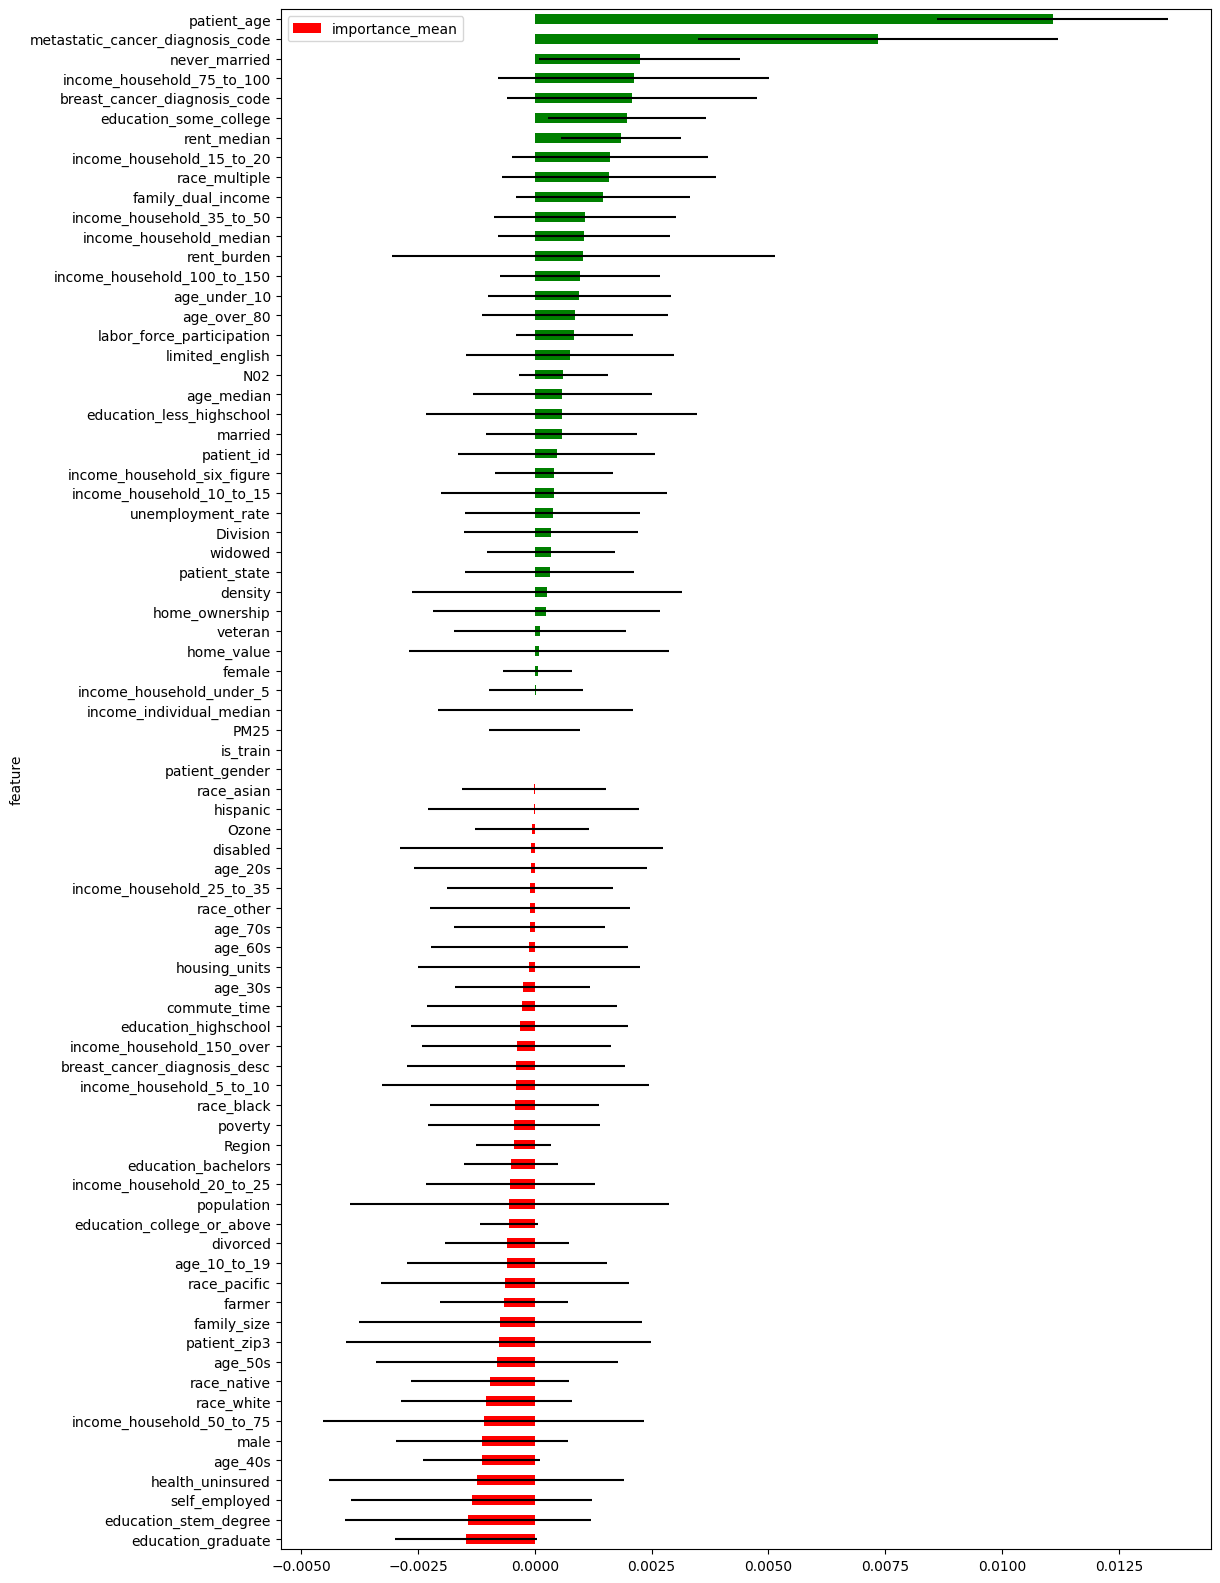

In [35]:
# extract a sample of the data
sample = train.sample(frac=1.0, random_state=0)
#sample.sort_values("AvSigVersion", inplace=True) # Sort by time for time split validation

# define the validation scheme
cv = KFold(n_splits=4, shuffle=False, random_state=None) # Don't shuffle to keep the time split split validation

# define the binary target and the features
dataset = Dataset(df=sample, target="DiagPeriodL90D", features=[col for col in train.columns if col != "DiagPeriodL90D"])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

# LGBM-8fold with features removed using LOFO

In [36]:
feature_col = np.setdiff1d(train.columns,['DiagPeriodL90D', 'patient_id','education_graduate','education_stem_degree','self_employed',
                                          'health_uninsured','age_40s','male','income_household_new_50_to_75','race_white','race_native',
                                          'age_50s','patient_zip3','family_size','farmer','race_pacific','divorced']) 
                                            
target = 'DiagPeriodL90D'

train_X = train[feature_col]
train_y = train[target]

test_X = test[feature_col]

# split train into tr and val

tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.20, random_state=1)

In [37]:
train_X = train_X.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

In [38]:
%%time 

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
#kf = KFold(n_splits=8, shuffle=True, random_state=42)

auc_score_list = []
model_predsLGBM = []

#kf.get_n_splits(train_X)
#print(kf)
print(skf)
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={val_index}")
    tr_X = train_X.loc[train_index] # 7/8th of training set is here
    val_X = train_X.loc[val_index] # 1/8th of training set is here
    
    tr_y = train_y.loc[train_index] # 7/8th of training set classes are here
    val_y = train_y.loc[val_index] # 1/8th of training set classes are here
    
    #building the model 
    
    clf = LGBMClassifier(#objective='binary',
    #boosting_type='gbdt',
    colsample_bytree=0.60,
    reg_lambda=1.00,
    reg_alpha=1.00,
    learning_rate=0.01,
     max_depth=6,
    min_child_samples=3,
    min_child_weight=8.00162004247609,
    #min_gain_to_split=0.05772859122473113,
    n_estimators=1500,
    num_leaves=63,
    subsample=0.90,
    #device='gpu',
    verbosity=-1,
    random_state=42) # model initializing
    
    ## training
    clf.fit(tr_X, tr_y) # building model on 7/8th of training set features and labels
    val_fold_preds = clf.predict_proba(val_X)[:,1] # validating model (get predictions) on 1/8th of training set features and labels on val set
    
    ## local validation
 
    #calculating auc for each fold
    auc_score = roc_auc_score(val_y,val_fold_preds)
    auc_score_list.append(auc_score)
    print("fold: ", i, ". auc_score: ", auc_score)
    
    ## predictions for lb
    #Oof model prediction
    test_fold_preds = clf.predict_proba(test_X)[:,1] # get predictions on entire test set
    model_predsLGBM.append(test_fold_preds) # saving these test predictions into a list

StratifiedKFold(n_splits=8, random_state=42, shuffle=True)
fold:  0 . auc_score:  0.7871868288019277
fold:  1 . auc_score:  0.7946608648960134
fold:  2 . auc_score:  0.7947297651843106
fold:  3 . auc_score:  0.7834145021645023
fold:  4 . auc_score:  0.8057328076402477
fold:  5 . auc_score:  0.801972004549015
fold:  6 . auc_score:  0.7892065770628701
fold:  7 . auc_score:  0.8052084255098798
CPU times: total: 1min 30s
Wall time: 22.6 s


In [39]:
np.mean(auc_score_list) 

0.7952639719760958

In [40]:
model_predsLGBM_mean = np.mean(model_predsLGBM, axis=0)

In [41]:
model_predsLGBM_mean

array([0.9045733 , 0.73713062, 0.80141118, ..., 0.930591  , 0.04436021,
       0.85565828])

# Modeling through XGBfir to get the important feature interaction

In [42]:
xgb_hyper_params = { 'n_estimators' : 700, 'eta': .08, 'max_depth': 6, 
                      'subsample' : 0.90, 
                      'colsample_bytree' : 0.90 }

In [43]:
%%time

xgb_classifier = XGBClassifier(**xgb_hyper_params)
xgb_classifier.fit(train_X, train_y)
val_preds = xgb_classifier.predict_proba(val_X)[:,1]

CPU times: total: 41.6 s
Wall time: 5.59 s


In [44]:
xgbfir.saveXgbFI(xgb_classifier, feature_names=train_X.columns, OutputXlsxFile = 'WidsFeatsInt.xlsx') 

In [45]:
panel['BCcode_MCcode'] = panel['breast_cancer_diagnosis_code'] * panel['metastatic_cancer_diagnosis_code']
panel['BCcode_Age'] = panel['breast_cancer_diagnosis_code'] * panel['patient_age']
panel['BCcode_Disabled']  = panel['breast_cancer_diagnosis_code'] * panel['disabled']
panel['BCcode_Rent'] = panel['breast_cancer_diagnosis_code'] * panel['rent_median']
panel['BCcode_BCcode'] = panel['breast_cancer_diagnosis_code'] * panel['breast_cancer_diagnosis_code'] 
panel['age30_BC_code'] = panel['age_30s'] * panel['breast_cancer_diagnosis_code'] 
panel['BCcode_IncomeUnder5'] = panel['breast_cancer_diagnosis_code'] * panel['income_household_under_5']
panel['BCdesc_Age'] = panel['breast_cancer_diagnosis_desc'] * panel['patient_age'] 
panel['BCcode_Poverty']  = panel['breast_cancer_diagnosis_code'] * panel['poverty']
panel['BCcode_PM25']  = panel['breast_cancer_diagnosis_code'] * panel['PM25']

In [46]:
panel['BC_code_MC_code_Age'] = panel['breast_cancer_diagnosis_code'] * panel['metastatic_cancer_diagnosis_code'] * panel['patient_age']
panel['BC_code_MC_code_MC_code'] = panel['breast_cancer_diagnosis_code'] * panel['metastatic_cancer_diagnosis_code'] * panel['metastatic_cancer_diagnosis_code']
panel['BC_code_IncomeUnder5_MC_code'] = panel['breast_cancer_diagnosis_code'] * panel['income_household_under_5'] * panel['metastatic_cancer_diagnosis_code']
panel['BCcode_Disabled_PatientAge']  = panel['breast_cancer_diagnosis_code'] * panel['disabled'] * panel['patient_age']
panel['BCcode_Hispanic_Rent'] = panel['breast_cancer_diagnosis_code'] * panel['hispanic'] * panel['rent_median']
panel['BCcode_State_Rent'] = panel['breast_cancer_diagnosis_code'] * panel['patient_state'] * panel['hispanic'] * panel['rent_median']
panel['BCcode_Disabled_Rent']  = panel['breast_cancer_diagnosis_code'] * panel['disabled'] * panel['rent_median']
panel['BCcode_BCcode_Disabled'] = panel['breast_cancer_diagnosis_code'] * panel['breast_cancer_diagnosis_code'] * panel['disabled']
panel['BCdesc_BCdesc_BCdesc'] = panel['breast_cancer_diagnosis_desc'] * panel['breast_cancer_diagnosis_desc'] * panel['breast_cancer_diagnosis_desc']
panel['BCcode_BCdesc_Disabled'] = panel['breast_cancer_diagnosis_code'] * panel['breast_cancer_diagnosis_desc'] * panel['disabled']

In [47]:
#assigning dfs back to their respective datasets
train = panel.loc[(panel['is_train'] == 1)]
test = panel.loc[(panel['is_train'] == 0)]

In [48]:
train = train.drop(['is_train'], axis=1)
test = test.drop(['is_train'], axis=1)

In [49]:
test.shape, train.shape

((5792, 98), (12906, 98))

In [50]:
feature_col = np.setdiff1d(train.columns,['DiagPeriodL90D', 'patient_id'])
target = 'DiagPeriodL90D'

train_X = train[feature_col]
train_y = train[target]

test_X = test[feature_col]
test_X = test_X[train_X.columns]

# split train into tr and val

tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.20, random_state=1)

In [51]:
%%time 
​
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
#kf = KFold(n_splits=8, shuffle=True, random_state=42)
​
auc_score_list = []
model_predsLGBM = []
​
#kf.get_n_splits(train_X)
#print(kf)
print(skf)
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={val_index}")
    tr_X = train_X.loc[train_index] # 7/8th of training set is here
    val_X = train_X.loc[val_index] # 1/8th of training set is here
    
    tr_y = train_y.loc[train_index] # 7/8th of training set classes are here
    val_y = train_y.loc[val_index] # 1/8th of training set classes are here
    
    #building the model 
    
    clf = LGBMClassifier(#objective='binary',
    #boosting_type='gbdt',
    colsample_bytree=0.60,
    reg_lambda=1.00,
    reg_alpha=1.00,
    learning_rate=0.01,
    max_depth=6,
    min_child_samples=3,
    min_child_weight=8.00162004247609,
    #min_gain_to_split=0.05772859122473113,
    n_estimators=1500,
    num_leaves=63,
    subsample=0.90,
    #device='gpu',
    verbosity=-1,
    random_state=42) # model initializing
    
    ## training
    clf.fit(tr_X, tr_y) # building model on 7/8th of training set features and labels
    val_fold_preds = clf.predict_proba(val_X)[:,1] # validating model (get predictions) on 1/8th of training set features and labels on val set
    
    ## local validation
 
    #calculating auc for each fold
    auc_score = roc_auc_score(val_y,val_fold_preds)
    auc_score_list.append(auc_score)
    print("fold: ", i, ". auc_score: ", auc_score)
    
    ## predictions for lb
    #Oof model prediction
    test_fold_preds = clf.predict_proba(test_X)[:,1] # get predictions on entire test set
    model_predsLGBM.append(test_fold_preds) # saving these test predictions into a list
    

SyntaxError: invalid non-printable character U+200B (<unknown>, line 1)

In [ ]:
np.mean(auc_score_list)

In [ ]:
model_predsLGBM_mean = np.mean(model_predsLGBM, axis=0)

# Lgbm-8FOLD using LOFO and XGBfir(both)

In [ ]:
feature_col = np.setdiff1d(train.columns,['DiagPeriodL90D', 'patient_id','education_graduate','education_stem_degree','self_employed',
                                          'health_uninsured','age_40s','male','income_household_new_50_to_75','race_white','race_native',
                                          'age_50s','patient_zip3','family_size','farmer','race_pacific','divorced']) 
target = 'DiagPeriodL90D'

train_X = train[feature_col]
train_y = train[target]

test_X = test[feature_col]

In [ ]:
test_X.shape

In [ ]:
%%time 

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
#kf = KFold(n_splits=8, shuffle=True, random_state=42)

auc_score_list = []
model_predsLGBM = []

#kf.get_n_splits(train_X)
#print(kf)
print(skf)
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={val_index}")
    tr_X = train_X.loc[train_index] # 7/8th of training set is here
    val_X = train_X.loc[val_index] # 1/8th of training set is here
    
    tr_y = train_y.loc[train_index] # 7/8th of training set classes are here
    val_y = train_y.loc[val_index] # 1/8th of training set classes are here
    
    #building the model 
    
    clf = LGBMClassifier(#objective='binary',
    #boosting_type='gbdt',
    colsample_bytree=0.60,
    reg_lambda=1.00,
    reg_alpha=1.00,
    learning_rate=0.01,
    max_depth=6,
    min_child_samples=3,
    min_child_weight=8.00162004247609,
    #min_gain_to_split=0.05772859122473113,
    n_estimators=1500,
    num_leaves=63,
    subsample=0.90,
    #device='gpu',
    verbosity=-1,
    random_state=42) # model initializing
    
    ## training
    clf.fit(tr_X, tr_y) # building model on 7/8th of training set features and labels
    val_fold_preds = clf.predict_proba(val_X)[:,1] # validating model (get predictions) on 1/8th of training set features and labels on val set
    
    ## local validation
 
    #calculating auc for each fold
    auc_score = roc_auc_score(val_y,val_fold_preds)
    auc_score_list.append(auc_score)
    print("fold: ", i, ". auc_score: ", auc_score)
    
    ## predictions for lb
    #Oof model prediction
    test_fold_preds = clf.predict_proba(test_X)[:,1] # get predictions on entire test set
    model_predsLGBM.append(test_fold_preds) # saving these test predictions into a list

In [ ]:
np.mean(auc_score_list)